# Advanced CNN training
This notebook demonstrates how to use classes from `opensoundscape.torch.models.cnn` and architectures created using `opensoundscape.torch.architectures.cnn_architectures` to

- choose between single-target and multi-target model behavior

- modify learning rates, learning rate decay schedule, and regularization

- choose from various CNN architectures

- train a multi-target model with a special loss function

- use strategic sampling for imbalanced training data

- customize preprocessing: train on spectrograms with a bandpassed frequency range

Rather than demonstrating their effects on training (model training is slow!), most examples in this notebook either don't train the model or "train" it for 0 epochs for the purpose of demonstration.

For introductory demos (basic training, prediction, saving/loading models), see the ["Beginner-friendly training and prediction with CNNs" tutorial](tutorials/cnn.html) (cnn.ipynb). 

In [1]:
from opensoundscape.preprocess import preprocessors
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures

import torch
import pandas as pd
from pathlib import Path
import numpy as np
import random 
import subprocess

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

## Prepare audio data

### Download labeled audio files

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

If you already have these files, you can skip or comment out this cell

In [2]:
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      5      0 --:--:--  0:00:01 --:--:--     9
100 9499k  100 9499k    0     0  4521k      0  0:00:02  0:00:02 --:--:-- 20.1M


CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

### Load dataframe of files and one-hot labels

We need a dataframe with file paths in the index, so we manipulate the included one_hot_labels.csv slightly

See the "Basic training and prediction with CNNs" tutorial for more details.


In [3]:
# load one-hot labels dataframe
labels = pd.read_csv('./woodcock_labeled_data/one_hot_labels.csv').set_index('file')
# prepend the folder location to the file paths
labels.index = pd.Series(labels.index).apply(lambda f: './woodcock_labeled_data/'+f)
#create class list
classes = labels.columns
#inspect
labels.head()

,present,absent
file,,
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,1,0
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,0,1
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,1,0
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,1,0
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,1,0


### Split into train and validation sets

Randomly split the data into training data and validation data.

In [4]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(labels, test_size=0.2, random_state=0)
print(f"created train_df (len {len(train_df)}) and valid_df (len {len(valid_df)})")

created train_df (len 23) and valid_df (len 6)


## Creating a model
We initialize a model object by specifying the architecture, a list of classes, and the duration of individual samples in seconds

In [5]:
arch = cnn_architectures.resnet50(num_classes=len(classes))
model = cnn.CNN(arch,classes,sample_duration=2.0)

Alternatively, we can specify the name of an architecture as a string (see Cnn Architectures below for details or use `cnn_architectures.list_architectures()` for options)

In [6]:
model = cnn.CNN('resnet18',classes,2.0)

### Single-target versus multi-target
One important decision is whether your model is single-target (exactly one label per sample) or multi-target (any number of labels per sample, including 0). Single-target models have a softmax activation layer which forces the sum of all class scores to be 1.0. By default, models are created as multi-target, but you can set `single_target=True` either when creating the object or afterwards.

In [7]:
#change the model to be single_target
model.single_target = True

#or specify single_target when you create the object
model = cnn.CNN(arch,classes,2.0,single_target=True)

## Model training parameters
We can modify various parameters about model training, including:

* The learning rate
* The learning rate schedule
* Weight decay for regularization

Let's take a peek at the current parameters, stored in a dictionary.

In [8]:
model.optimizer_params

{'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005}

### Learning rates
The learning rate determines how much the model's weights change every time it calculates the loss function. 

Faster learning rates improve the speed of training and help the model leave local minima as it learns to classify, but if the learning rate is too fast, the model may not successfully fit the data or its fitting might be unstable.

Often after training a model for a while at a relatively high learning rate (think 0.01), we might want to "fine tune" the model by training for a few epochs with a lower learning rate. Let's set a low learning rate for fine tuning:

In [9]:
model.optimizer_params['lr']=0.001

### Separate learning rates for feature and classifier blocks

For ResNet architectures, we can modify the learning rates for the feature extration and classification blocks of the network separately. For example, we can specify a relatively fast learning rate for classifier and slower one for features, if we think the features from a pre-trained model are close to optimal but we have a different set of classes than the pre-trained model. We first use a helper function to separate the feature and classifier parameters, then specify parameters for each:

In [10]:
from opensoundscape.torch.models.cnn import separate_resnet_feat_clf

In [11]:
r18_model = cnn.CNN('resnet18',classes,2.0)
print(r18_model.optimizer_params)

separate_resnet_feat_clf(r18_model) #in place operation!

#now we can specify separate parameters for the 'feature' and 'classifier' portions of the network
r18_model.optimizer_params['feature']['lr'] = 0.001
r18_model.optimizer_params['classifier']['lr'] = 0.01

r18_model.optimizer_params

{'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005}


{'feature': {'lr': 0.001, 'momentum': 0.9, 'weight_decay': 0.0005},
 'classifier': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005}}

### Learning rate schedule
It's often helpful to decrease the learning rate over the course of training. By reducing the amount that the model's weights are updated as time goes on, this causes the learning to gradually switch from coarsely searching across possible weights to fine-tuning the weights.

By default, the learning rates are multiplied by 0.7 (the learning rate "cooling factor") once every 10 epochs (the learning rate "update interval"). 

Let's modify that for a very fast training schedule, where we want to multiply the learning rates by 0.1 every epoch. 

In [12]:
model.lr_cooling_factor = 0.1
model.lr_update_interval = 1

### Regularization weight decay
Pytorch optimizers perform [L2 regularization](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization), giving the optimizer an incentive for the model to have small weights rather than large weights. The goal of this regularization is to reduce overfitting to the training data by reducing the complexity of the model. 

Depending on how much emphasis you want to place on the L2 regularization, you can change the weight decay parameter. By default, it is 0.0005. The higher the value for the "weight decay" parameter, the more the model training algorithm prioritizes smaller weights.

In [13]:
model.optimizer_params['weight_decay']=0.001

## Selecting CNN architectures

The  [`opensoundscape.torch.architectures.cnn_architectures`](https://github.com/kitzeslab/opensoundscape/blob/master/opensoundscape/torch/architectures/cnn_architectures.py) module provides functions to create several common CNN architectures. These architectures are built in to pytorch, but the OpenSoundscape module helps us out by reshaping the final layer to match the number of classes we have. 

You could also create a custom architecture by subclassing an existing pytorch model or writing one from scratch (the minimum requirement is that it subclasses `torch.nn.Module` - it should at least have `.forward()` and `.backward()` methods.

In general, we can create any pytorch model architecture and pass it to the `architecture` argument when creating a model in opensoundscape. We can choose whether to use pre-trained (ImageNet) weights or start from scratch (`use_pretrained=False` for random weights). For instance, lets create an alexnet architecture with random weights:

In [14]:
my_arch = cnn_architectures.alexnet(num_classes=len(classes),use_pretrained=False)

For convenience, we can also initialize a model object by providing the name of an architecture as a string, rather than the architecture object. For a list of valid architecture names, use `cnn_architectures.list_architectures()`. Note that these will use default architecture parameters, including using pre-trained ImageNet weights. If you don't want to use pre-trained weights, follow the method above of creating the architecture and passing it to the initialization of CNN.  

In [15]:
print(cnn_architectures.list_architectures())

['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'alexnet', 'vgg11_bn', 'squeezenet1_0', 'densenet121', 'inception_v3']


In [16]:
model = cnn.CNN(architecture='resnet18',classes=classes, sample_duration=2.0)

### Pretrained weights

In OpenSoundscape, by default, model architectures are initialized with weights pretrained on the [ImageNet](https://www.image-net.org/) image database. It takes some time for pytorch to download these weights from an online repository the first time an instance of a particular architecture is created with pretrained weights - pytorch will do this automatically and only once.

Using pretrained weights often speeds up training significantly, as the representation learned from ImageNet is a good start at beginning to interpret spectrograms, even though they are not true "pictures."

If you prefer not to use pre-trained weights, or if you don't have an internet connection, you can specify `use_pretrained` argument to `False`, when creating an architecture:

In [17]:
arch = cnn_architectures.alexnet(num_classes=10,use_pretrained=False)

### Freezing the feature extractor

Convolutional Neural Networks can be thought of as having two parts: a **feature extractor** which learns how to represent/"see" the input data, and a **classifier** which takes those representations and transforms them into predictions about the class identity of each sample.

You can freeze the feature extractor if you only want to train the final classification layer of the network but not modify any other weights. This could be useful for applying pre-trained classifiers to new data, i.e. "transfer learning". To do so, set the `freeze_feature_extractor` argument to `True` when you create an architecture.


In [18]:
# See "InceptionV3 architecture" section below for more information
arch = cnn_architectures.resnet50(num_classes=10, freeze_feature_extractor=True, use_pretrained=False)

### InceptionV3 class
The Inception architecture requires slightly different training and preprocessing from the ResNet architectures and the other architectures implemented in OpenSoundscape (see below), because:

1) the input image shape must be 299x299, and

2) Inception's forward pass gives output + auxiliary output instead of a single output

The InceptionV3 class in `cnn` handles the necessary modifications in training and prediction for you, so use that instead of CNN:

In [19]:
from opensoundscape.torch.models.cnn import InceptionV3

#generate an Inception model
model = InceptionV3(classes=classes,use_pretrained=False,sample_duration=2)

#train and validate for 1 epoch
#note that Inception will complain if batch_size=1
model.train(train_df,valid_df,epochs=1,batch_size=4)

#predict
preds, _, _ = model.predict(valid_df)

/Users/SML161/opt/miniconda3/envs/opso_dev/lib/python3.8/site-packages/torchvision/models/inception.py:81: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '



Training Epoch 0
Epoch: 0 [batch 0/6 (0.00%)] 
	DistLoss: 0.888
Metrics:
Metrics:
	MAP: 0.511

Validation.
[]
Metrics:
	MAP: 0.500

Best Model Appears at Epoch 0 with Validation score 0.500.
[]


### Changing the architecture of an existing model (not recommended)
The architecture is stored in the model object's `.newtork` attribute. We can access parameters of the network or even replace it entirely. 

Note that replacing the architecture will completely remove anything the model has "learned" since the learned weights are a part of the architecture.

In [20]:
#initialize the AlexNet architecture
new_arch = cnn_architectures.densenet121(num_classes=2, use_pretrained=False)

# replace the alexnet architecture with the densenet architecture
model.network = new_arch

## Multi-target training with ResampleLoss

Training multi-target models (a.k.a. multi-label: there can be any number of positive labels on each sample) is challenging and can benefit from using a modified loss function. OpenSoundscape provides a loss function designed for training multi-target models. We recommend using this loss function when training multi-target models. You can add it to a class with an in-place helper function:

In [21]:
from opensoundscape.torch.models.cnn import use_resample_loss

In [22]:
model = cnn.CNN('resnet18',classes,2.0)
use_resample_loss(model)
print(model.loss_cls)

#use as normal...
#model.train(...)
#model.predict(...)

<class 'opensoundscape.torch.loss.ResampleLoss'>


/Users/SML161/opt/miniconda3/envs/opso_dev/lib/python3.8/site-packages/pandas/core/series.py:3247: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  other = Series(other)


## Training and predicting with custom preprocessors
The preprocessing tutorial gives in-depth descriptions of how to customize your preprocessing pipeline.

Here, we'll just give a quick example of tweaking the preprocessing pipeline: providing the CNN with a bandpassed spectrogram object instead of the full frequency range. 

It's good practice to create the validation from the training dataset (after any modifications are made), so that they perform the same preprocessing. You may or may not want to use augmentation on the validation dataset. 

### Example: Training on bandpassed spectrograms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Best Model Appears at Epoch 0 with Validation score 0.000.


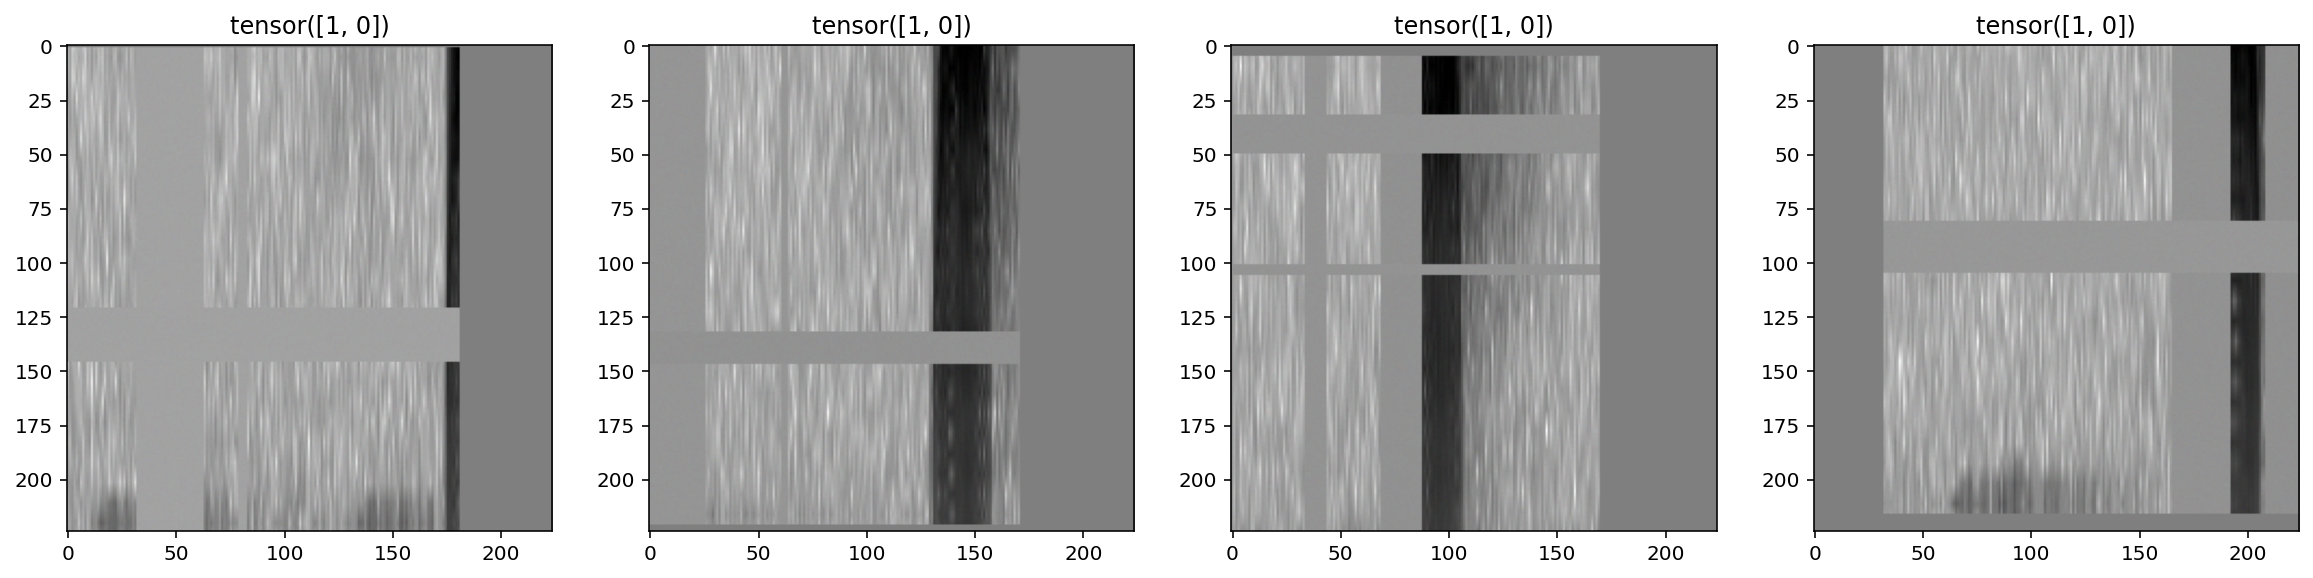

In [23]:
model = cnn.CNN('resnet18', classes, 2.0)

# change the min and max frequencies for the spectrogram bandpass action
model.preprocessor.pipeline.bandpass.set(min_f=3000, max_f=5000)

# inspect a few preprocessed samples (see basic CNN training and prediction tutorial for details)
from opensoundscape.preprocess.utils import show_tensor_grid
from opensoundscape.torch.datasets import AudioFileDataset
sample_of_4 = train_df.sample(n=4)
inspection_dataset = AudioFileDataset(sample_of_4, model.preprocessor) 
samples = [sample['X'] for sample in inspection_dataset]
labels = [sample['y'] for sample in inspection_dataset]
_ = show_tensor_grid(samples,4,labels=labels)

# now we can train and validate on the bandpassed spectrograms
model.train(train_df, valid_df, epochs=0)

If we predict using this model for prediction, it will use the same preprocessor settings, bandpassing the prediction samples in the same way as the training samples. 

### clean up
remove files

In [24]:
import shutil
shutil.rmtree('./woodcock_labeled_data')

for p in Path('.').glob('*.model'):
    p.unlink()